## IMPLEMENTATION OF ARIMA MODEL

In [60]:
import warnings
warnings.filterwarnings('ignore')

##### Libraries and Modules

In [61]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import specific tools for time series analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [62]:
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=6040114089c5dca4dc3da240a739e3a98c4155fd64f41d6b3b5b846309f4b57c
  Stored in directory: /root/.cache/pip/wheels/39/17/6f/66a045ea3d168826074691b4b787b8f324d3f646d755443fda
Successfully built googletrans
  Attempting uninstall: hyperframe
    Found existing installation: hyperframe 6.1.0
    Uninstalling hyperfram

In [63]:
from googletrans import Translator

translator = Translator()

##### Reading the Dataset

In [64]:
# Read the Excel file into a DataFrame, using only the specified columns
columns = ['CLORURO DE SODIO', 'LACTATO DE SODIO', 'METAMIZOL', 'PARACETAMOL', 'PROPOFOL', 'FECHA']
time_series = pd.read_excel('/content/df_time_series (1).xlsx', usecols=columns)

# Set the 'FECHA' column as the index of the DataFrame
time_series['FECHA'] = pd.to_datetime(time_series['FECHA'])
time_series = time_series.set_index('FECHA')
time_series.index.freq = '15D'

# Display the first few rows of the DataFrame
time_series.head()

,CLORURO DE SODIO,LACTATO DE SODIO,METAMIZOL,PARACETAMOL,PROPOFOL
FECHA,,,,,
2020-01-01,8085.68,8543.5,19910.44,11596.50,34.82
2020-01-16,19.00,0.0,7.56,3.00,0.00
2020-01-31,8748.72,9012.0,19368.24,11092.85,51.00
2020-02-15,73.50,0.0,2.52,3.00,1.00
2020-03-01,8229.89,7688.0,18505.16,11746.15,20.58


##### Exploratory Analysis - Measures of Central Tendency

In [65]:
# Display descriptive statistics for the time series data
time_series.describe().round(decimals=2)

,CLORURO DE SODIO,LACTATO DE SODIO,METAMIZOL,PARACETAMOL,PROPOFOL
count,96.00,96.00,96.00,96.00,96.00
mean,3980.92,3831.88,8841.91,6112.43,22.40
std,4340.49,4221.55,9617.88,6811.60,44.43
min,2.55,0.00,0.00,0.00,0.00
25%,54.96,0.00,0.00,0.00,0.97
50%,555.55,50.75,850.86,466.50,3.10
75%,8859.38,8379.12,19409.61,13571.42,29.17
max,10835.62,10458.00,23187.20,16272.32,323.57


##### Formation of Training and Test Sets

In [66]:
"""
    Split a time series into training and testing sets.

    Parameters:
    - series (pandas Series): The time series data to split.
    - test_size (int): The size of the testing set.

    Returns:
    - training (pandas Series): The training set.
    - test (pandas Series): The testing set.
"""
def train_test_split(series, test_size=10):
    split_index = len(series) - test_size
    training, test = series[:split_index], series[split_index:]
    return training, test

In [67]:
# Split the time series data into training and testing sets using the train_test_split function
training, test = train_test_split(time_series)

# Print the sizes of the training and testing sets
print('Training set size:', training.shape)
print('Test set size:', test.shape)

Training set size: (86, 5)
Test set size: (10, 5)


##### Distribution of The Time Series

In [68]:
"""
    Plot the distribution of a time series.

    Parameters:
    - series (str): The name of the series to plot.

    Returns:
    - None
"""
def plot_distribution(series):

    plt.figure(figsize=(16, 5))
    y_label = 'Cantidad (L)' if series == 'CLORURO DE SODIO' or series == 'LACTATO DE SODIO' else 'Cantidad (G)'

    plt.plot(training[series], label='Entrenamiento', linewidth=3, linestyle='solid')
    plt.plot(test[series], label='Prueba', linewidth=3, linestyle='solid')

    plt.grid(True, linestyle='--', alpha=0.8)

    plt.legend(fontsize=13)

    plt.xlabel('Meses', fontsize=13)
    plt.ylabel(y_label, fontsize=13)

    plt.title(f'Distribución de la serie de {series}'.upper(), fontsize=15)
    plt.legend(loc='upper left', fontsize=10)

    plt.show()

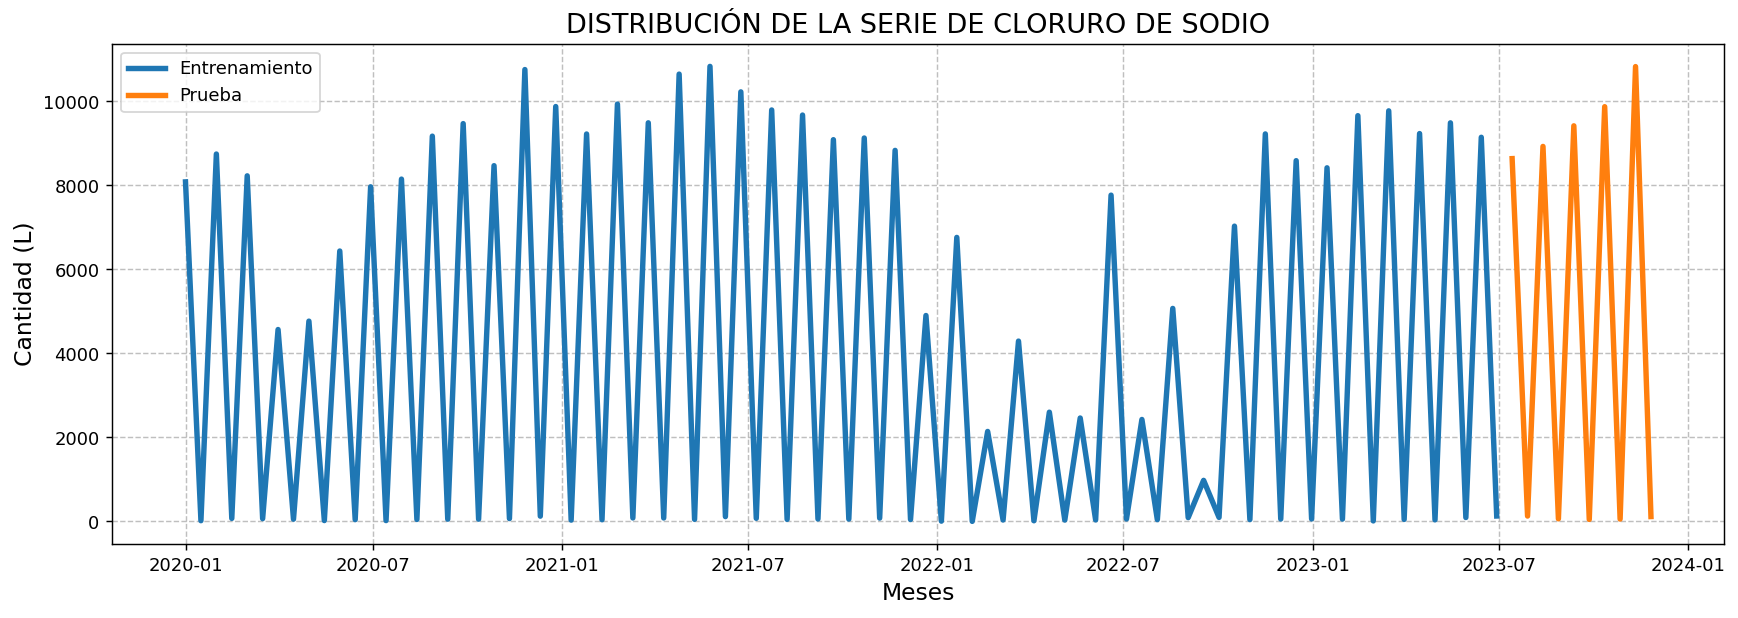

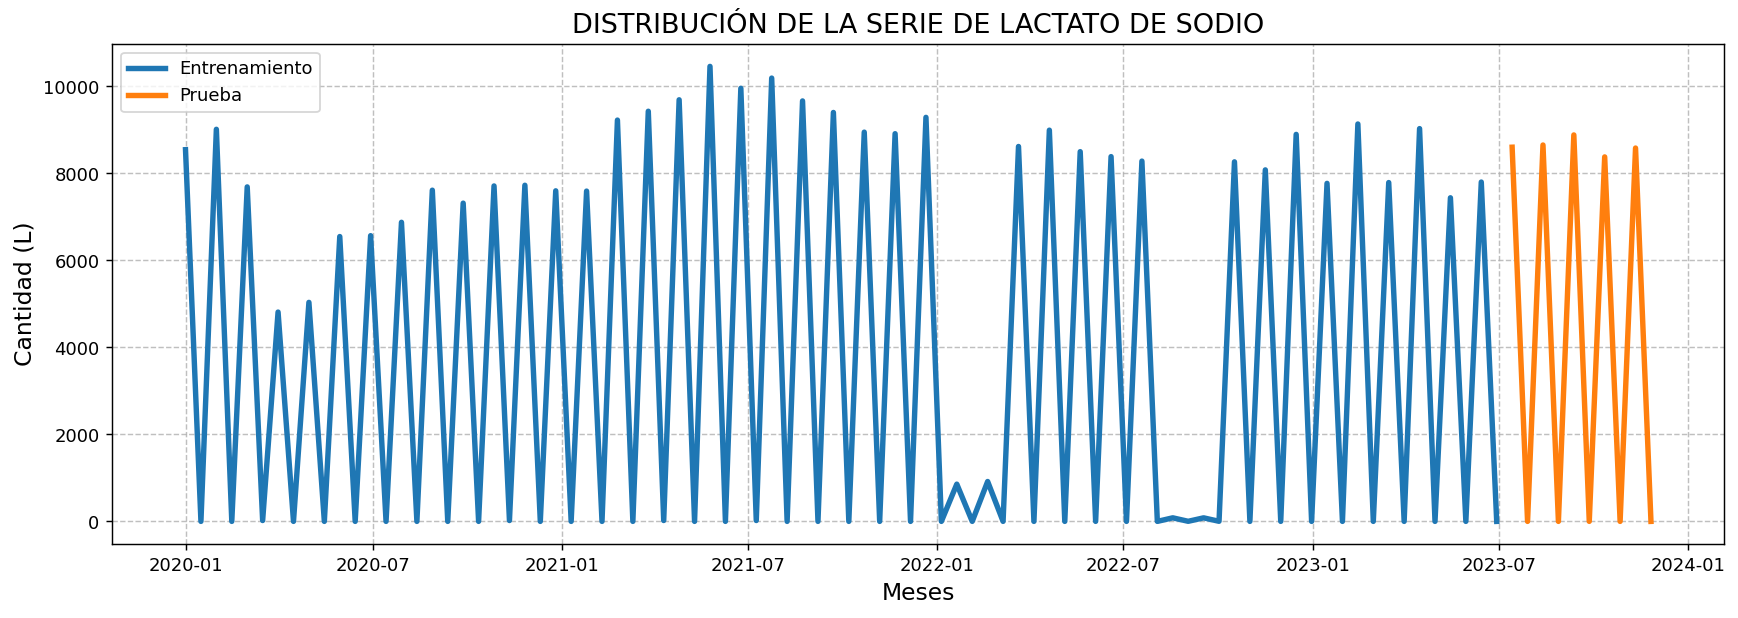

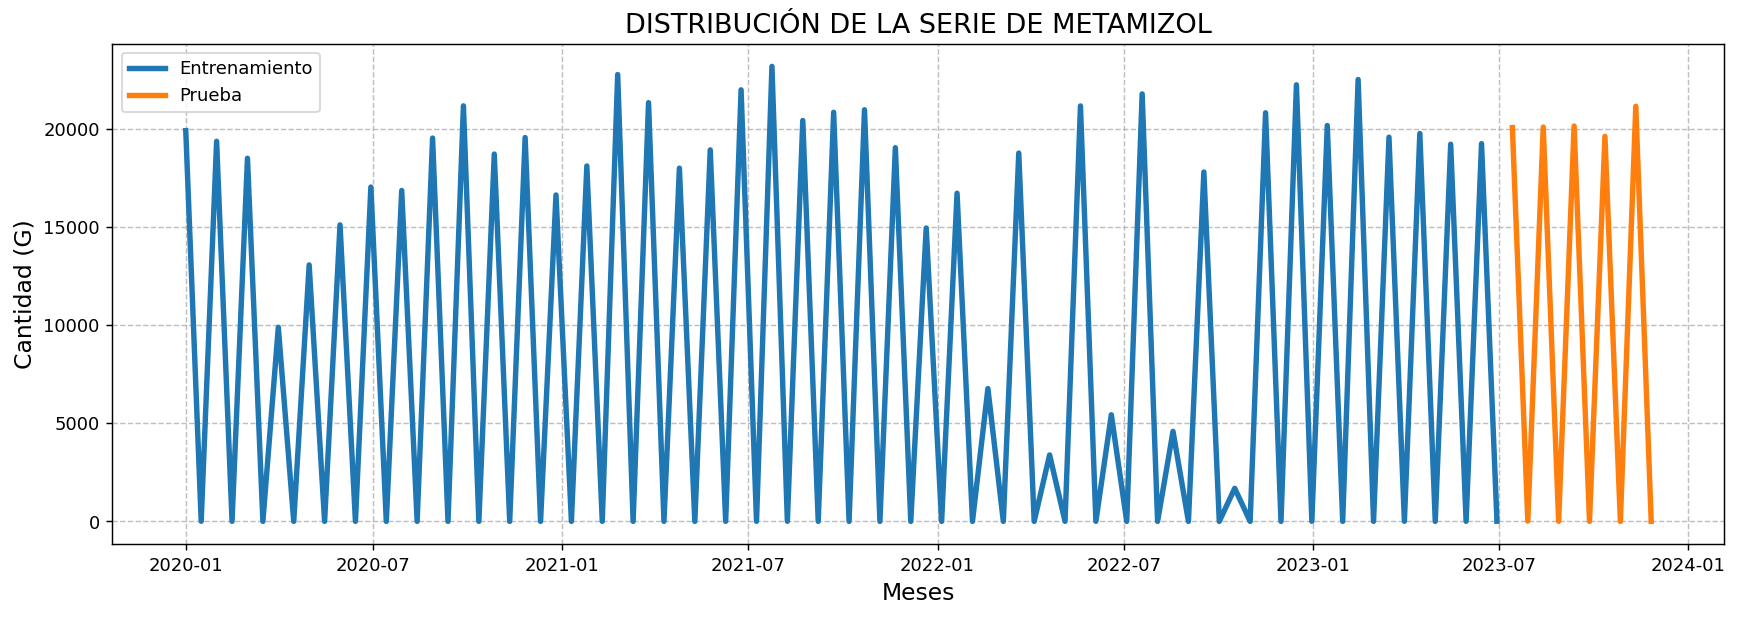

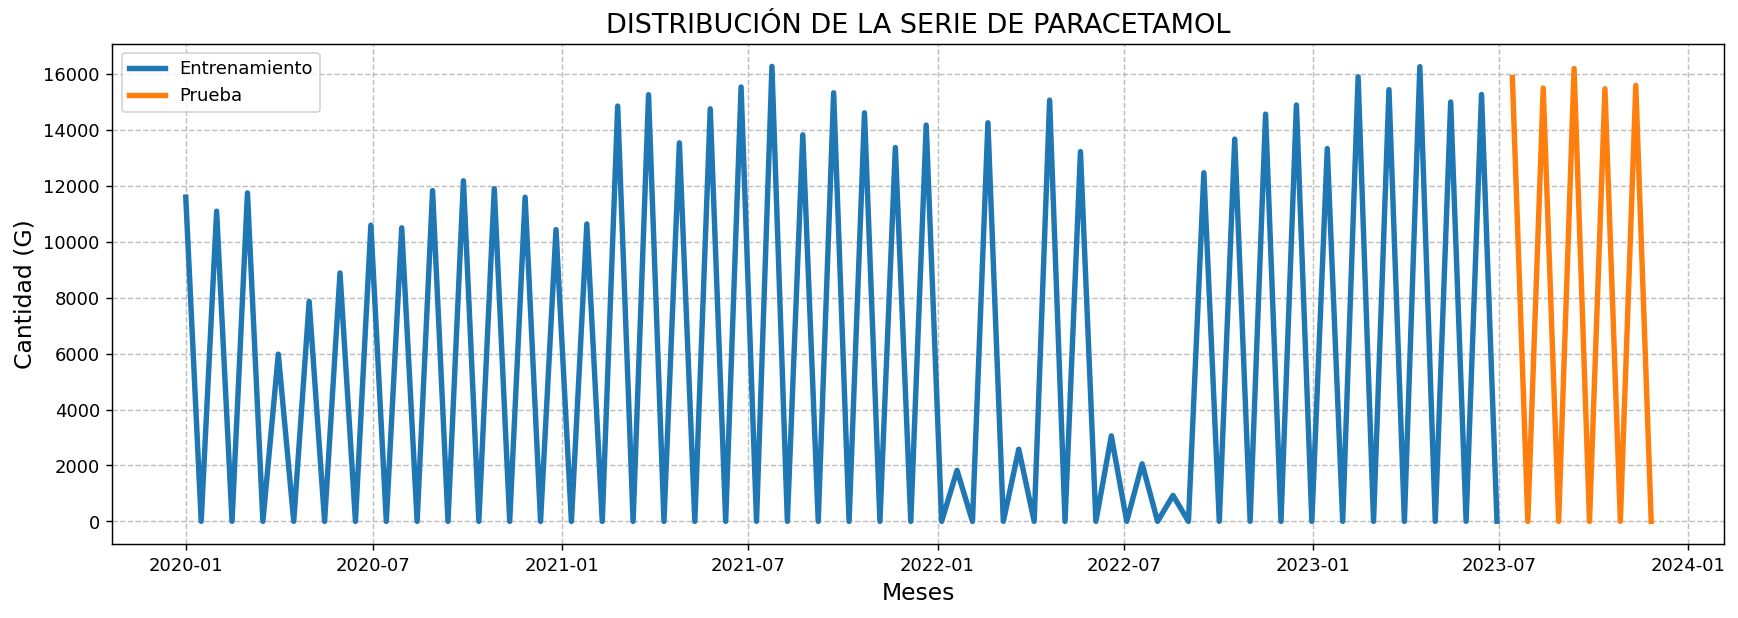

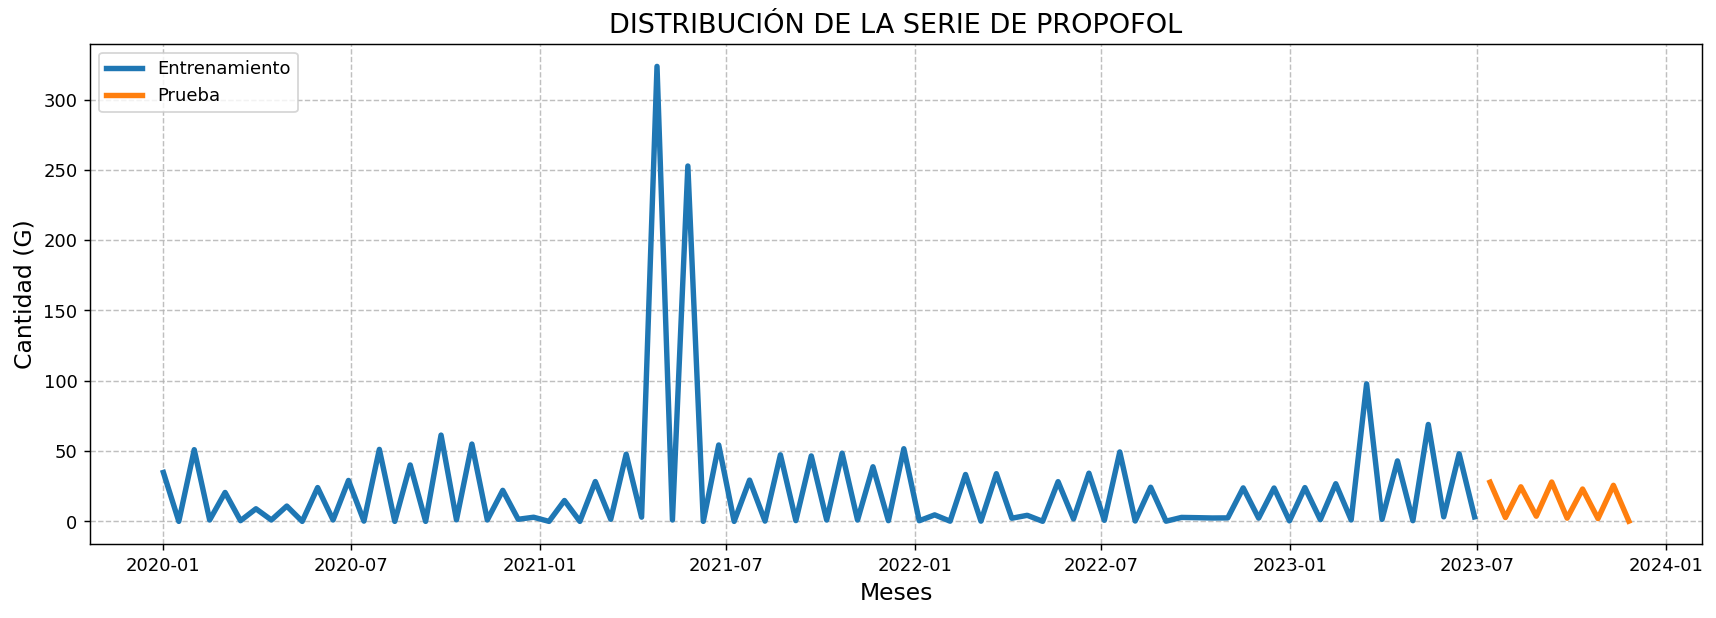

In [69]:
# Iterator to graph the distribution of all series
for series in time_series.columns:
    plot_distribution(series)

##### Stationarity Test on The Time Series

In [70]:
"""
    Perform stationarity test on each series in the given DataFrame.

    Parameters:
    - data (pandas DataFrame): DataFrame containing time series data.

    Returns:
    - adf_results (pandas DataFrame): DataFrame containing results of the Augmented Dickey-Fuller test.
    - non_stationary (list): List of column names for non-stationary series.
"""
def stationarity_test(data):
    non_stationary = []
    adf_list = []

    for column in data.columns:
        result = adfuller(data[column].dropna())

        if result[1] > 0.05:
            non_stationary.append(column)

        adf_list.append({
            'SERIE': column,
            'P-VALUE': round(result[1], 5),
            'TS (ADF)': round(result[0], 5),
            '5% CRITICAL': round(result[4]['5%'], 5),
            'STATE': 'Non-Stationary' if result[1] > 0.05 else 'Stationary'
        })

    return pd.DataFrame(adf_list), non_stationary

In [71]:
# Create a copy of the training set to work with
stationary_time_series = training.copy()

# Perform stationarity test on the training set
adf_results, non_stationary_series = stationarity_test(stationary_time_series)
adf_results

,SERIE,P-VALUE,TS (ADF),5% CRITICAL,STATE
0,CLORURO DE SODIO,0.43910,-1.68454,-2.89749,Non-Stationary
1,LACTATO DE SODIO,0.04614,-2.89323,-2.89841,Stationary
2,METAMIZOL,0.23618,-2.12093,-2.89749,Non-Stationary
3,PARACETAMOL,0.55947,-1.44716,-2.90039,Non-Stationary
4,PROPOFOL,0.00117,-4.05014,-2.89749,Stationary


##### Analysis of the Differencing Property for Non-Stationary Series

In [72]:
# Loop through each non-stationary series
for series in non_stationary_series:
    # Apply differencing to make the series stationary
    stationary_time_series.loc[:, series] = diff(stationary_time_series[series], k_diff=1)

In [73]:
# Perform stationarity test on the training set (stationary_time_series)
adf_results, _ = stationarity_test(stationary_time_series)
adf_results

,SERIE,P-VALUE,TS (ADF),5% CRITICAL,STATE
0,CLORURO DE SODIO,0.00000,-10.37673,-2.89749,Stationary
1,LACTATO DE SODIO,0.04614,-2.89323,-2.89841,Stationary
2,METAMIZOL,0.00000,-19.95822,-2.89749,Stationary
3,PARACETAMOL,0.00000,-5.86971,-2.90039,Stationary
4,PROPOFOL,0.00117,-4.05014,-2.89749,Stationary


##### Analysis of Autoregressive and Moving Average Properties (Parameters p and q)

In [74]:
"""
    Plot the autocorrelation and partial autocorrelation functions for a given series.

    Parameters:
    - series (str): The name of the series to plot.

    Returns:
    - None
"""
def plot_acf_pacf(series):
    plt.rcParams.update({'figure.figsize': (10, 5), 'figure.dpi': 130})
    _, ax = plt.subplots(1, 2)

    plot_acf(stationary_time_series[series].dropna(), lags=10, color='g', ax=ax[0])
    ax[0].set_ylim(-1, 1.1)
    ax[0].set_title(f'ACF - {series}'.upper(), fontsize=9)
    ax[0].grid(True, linestyle='--', alpha=0.8)
    ax[0].set_xlabel('Rezagos', fontsize=8)
    ax[0].set_ylabel('Magnitud', fontsize=8)

    plot_pacf(stationary_time_series[series].dropna(), lags=10, color='g', ax=ax[1])
    ax[1].set_ylim(-1, 1.1)
    ax[1].set_title(f'PACF - {series}'.upper(), fontsize=9)
    ax[1].grid(True, linestyle='--', alpha=0.8)
    ax[1].set_xlabel('Rezagos', fontsize=8)
    ax[1].set_ylabel('Magnitud', fontsize=8)

    plt.tight_layout()
    plt.show()

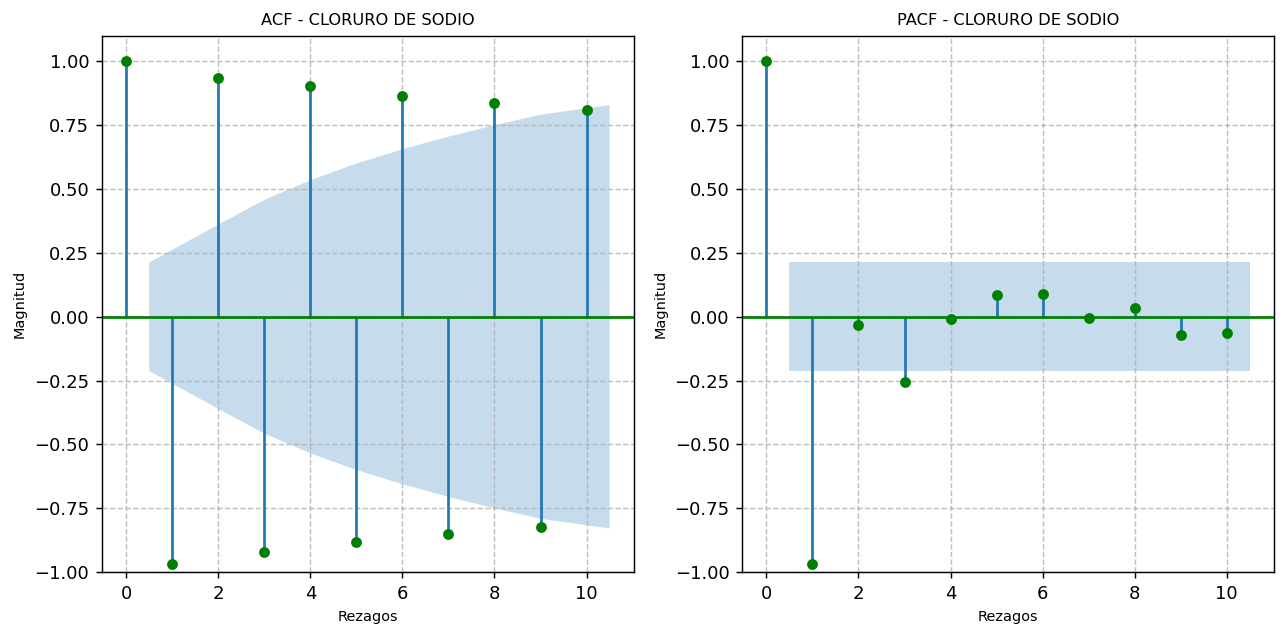

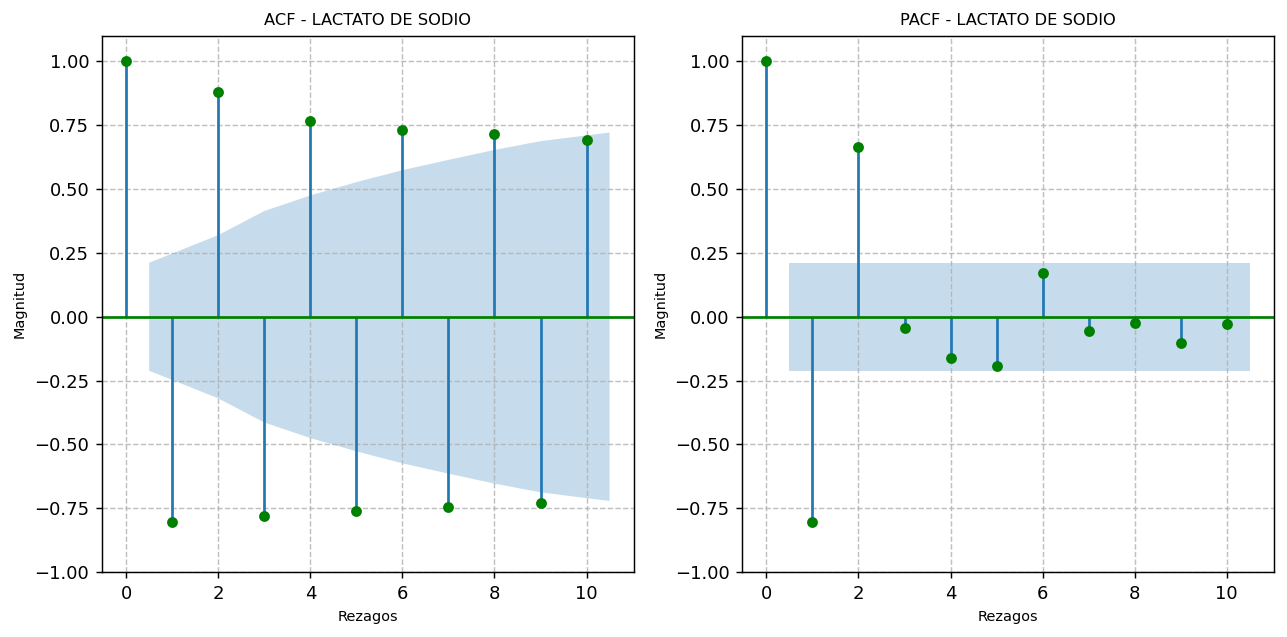

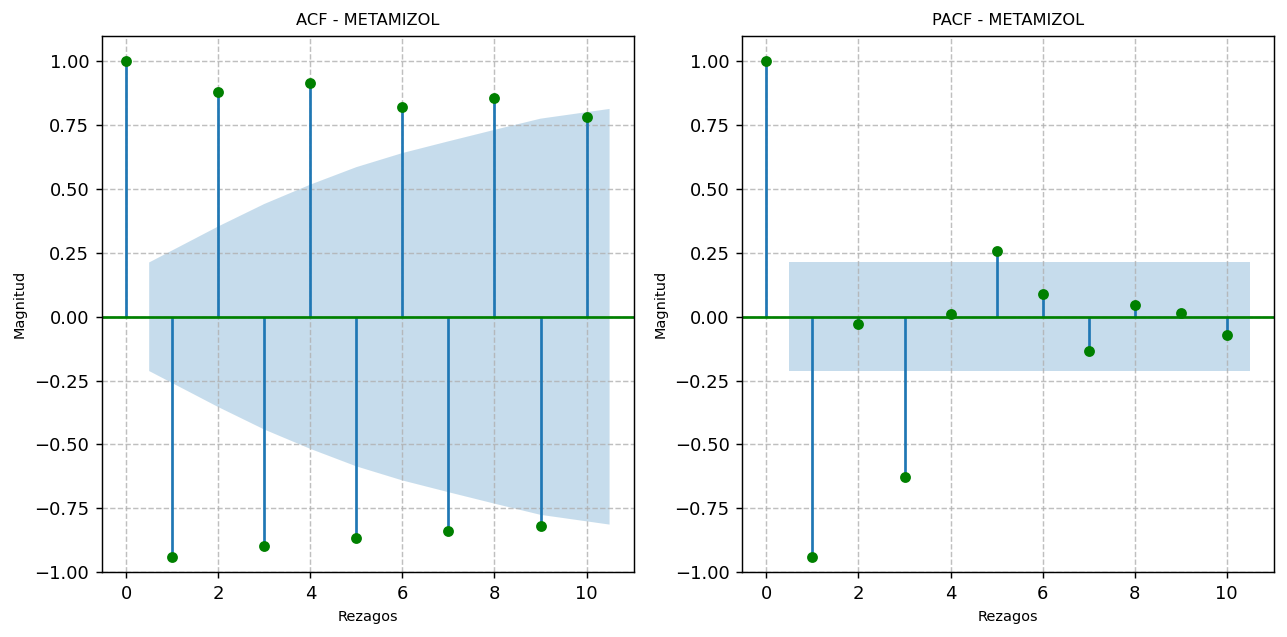

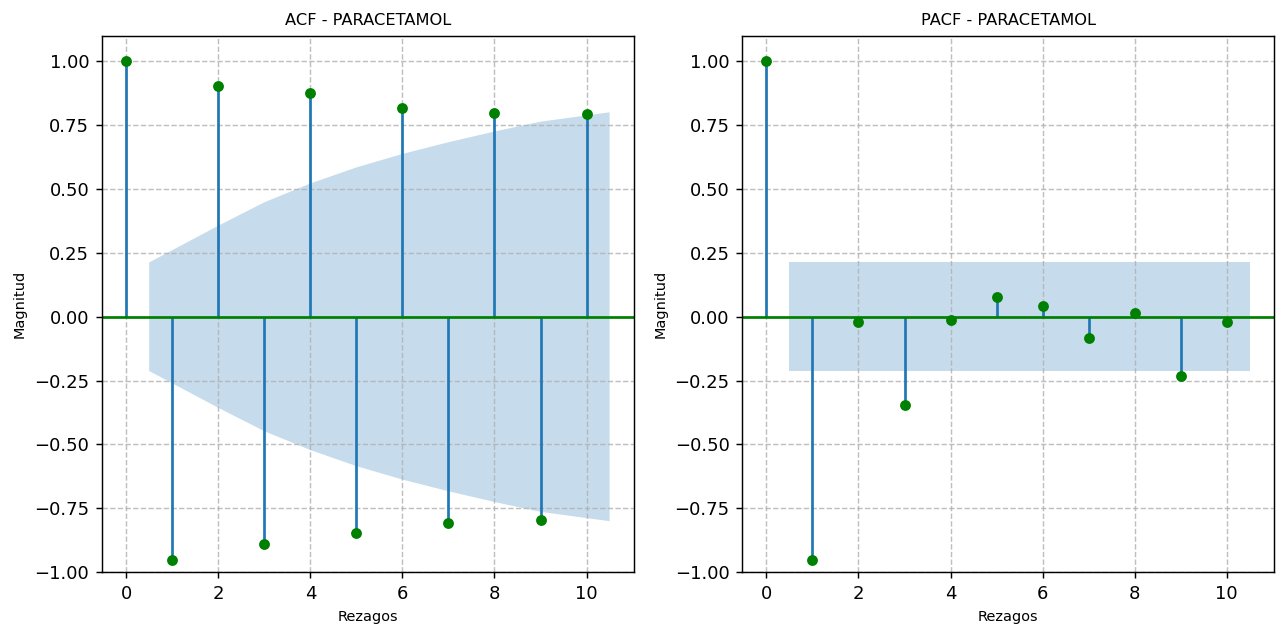

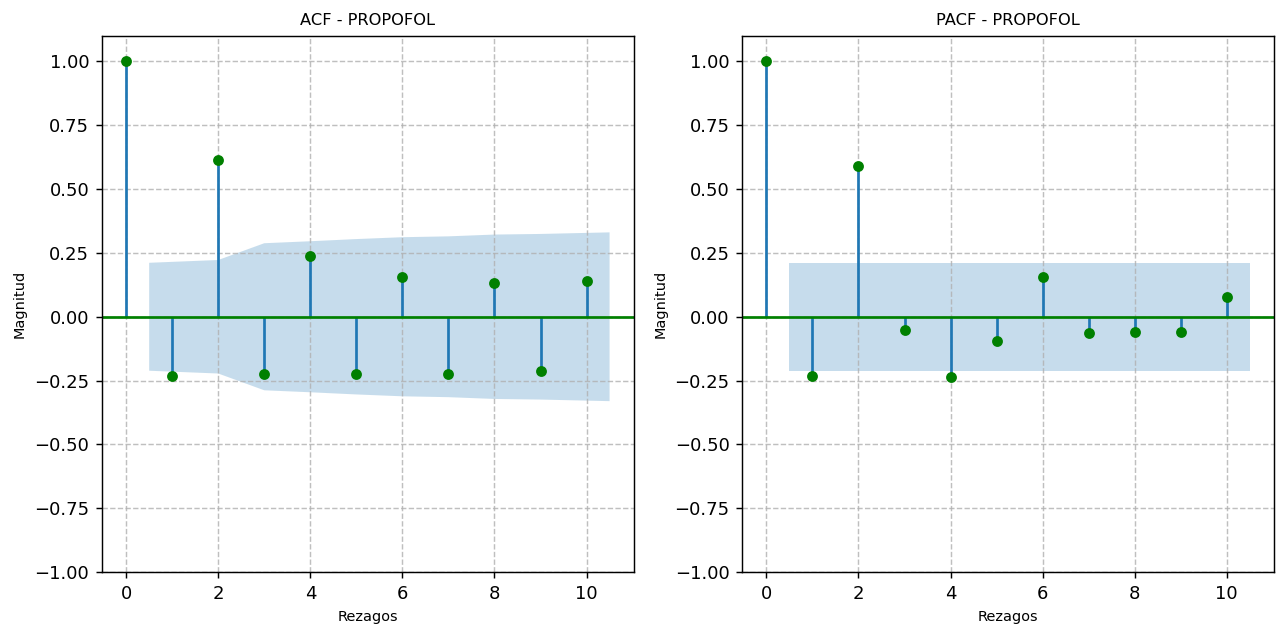

In [75]:
# Loop over each column in the time series and plot its autocorrelation and partial autocorrelation functions
for series in stationary_time_series.columns:
    plot_acf_pacf(series)

##### Implementation of The ARIMA Model

In [76]:
# List of dictionaries specifying series name and corresponding ARIMA model orders
config_list =[
    {'series': 'CLORURO DE SODIO', 'order':(3, 1, 3)},
    {'series': 'LACTATO DE SODIO', 'order':(3, 0, 3)},
    {'series': 'METAMIZOL', 'order':(3, 1, 3)},
    {'series': 'PARACETAMOL', 'order':(2, 1, 2)},
    {'series': 'PROPOFOL', 'order':(3, 0, 0)}
]

In [77]:
# Dictionary to store trained ARIMA models
trained_models = {}

# Iterate over each configuration in the config_list
for params in config_list:

    # Extract series name and ARIMA orders from the configuration
    series = params['series']
    order = params['order']

    # Fit an ARIMA model to the training data for the current series
    model = ARIMA(training[series], order=order)
    model_fit = model.fit()

    # Store the trained model in the dictionary
    trained_models[series] = model_fit

    # Print summary of each of the models
    print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       CLORURO DE SODIO   No. Observations:                   86
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -734.472
Date:                Thu, 03 Jul 2025   AIC                           1482.944
Time:                        20:54:37   BIC                           1500.043
Sample:                    01-01-2020   HQIC                          1489.822
                         - 06-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3608      0.242     -5.632      0.000      -1.834      -0.887
ar.L2         -1.0258      0.576     -1.781      0.075      -2.155       0.103
ar.L3         -0.6647      0.389     -1.711      0.0

##### Serial Autocorrelation Analysis - Ljung-Box Test

In [78]:
# Iterate over each trained ARIMA model
for series, model_fit in trained_models.items():
    # Perform the Ljung-Box test on the residuals of the model
    result = acorr_ljungbox(model_fit.resid, lags=[10])

    p_value = result.iloc[0, -1]

    # Print the result of the Ljung-Box test
    print(f'Ljung-Box Test for {series}: {p_value}')

Ljung-Box Test for CLORURO DE SODIO: 0.26239462398602464
Ljung-Box Test for LACTATO DE SODIO: 0.9963771278539687
Ljung-Box Test for METAMIZOL: 0.5767385674539438
Ljung-Box Test for PARACETAMOL: 0.12154397919257785
Ljung-Box Test for PROPOFOL: 0.6791455225593102


##### Analysis of Residual Errors

In [79]:
"""
    Plot the residual errors and their density for a given series.

    Parameters:
    - series (str): The name of the series.
    - model_fit (statsmodels ARIMA model): Fitted ARIMA model for the series.

    Returns:
    - None
"""
def plot_residual_errors(series, model_fit):
    plt.rcParams.update({'figure.figsize': (16, 5), 'figure.dpi': 130})

    _, ax = plt.subplots(1, 2)

    residuals = pd.DataFrame(model_fit.resid, columns=['residuos'])

    residuals.plot(title=f'Residuals for {series}'.upper(), ax=ax[0], color='blue')
    residuals.plot(kind='kde', title=f'Density of residual for {series}'.upper(), ax=ax[1], color='blue')

    plt.grid(True, linestyle='--', alpha=0.8)

    plt.xlabel('Value', fontsize=8)
    ax[0].set_xlabel('Rezagos', fontsize=8)
    ax[0].set_ylabel('Valor Residuo', fontsize=8)
    ax[1].set_xlabel('Valor Residuo', fontsize=8)
    ax[1].set_ylabel('Densidad', fontsize=8)
    plt.savefig(f"fig_3_{series}.png")

    plt.show()

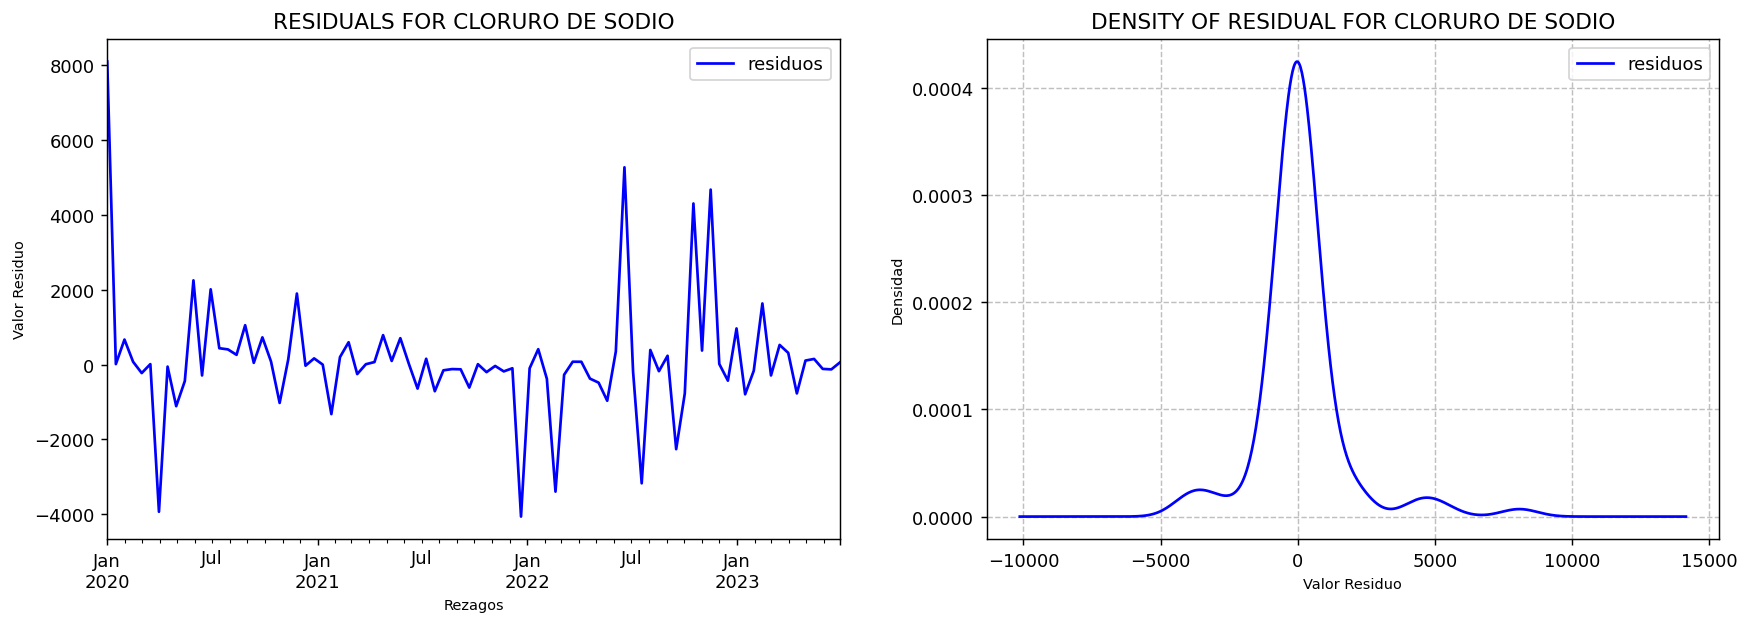

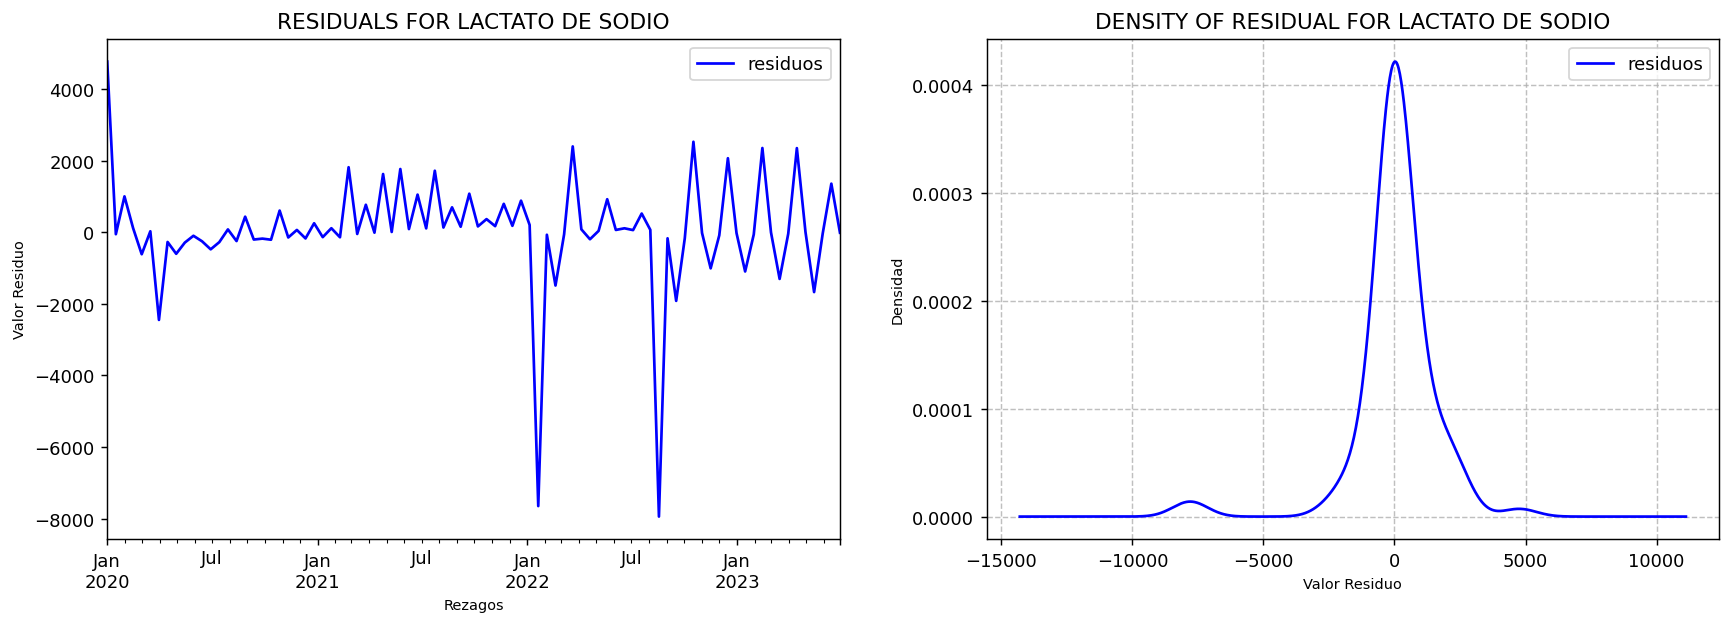

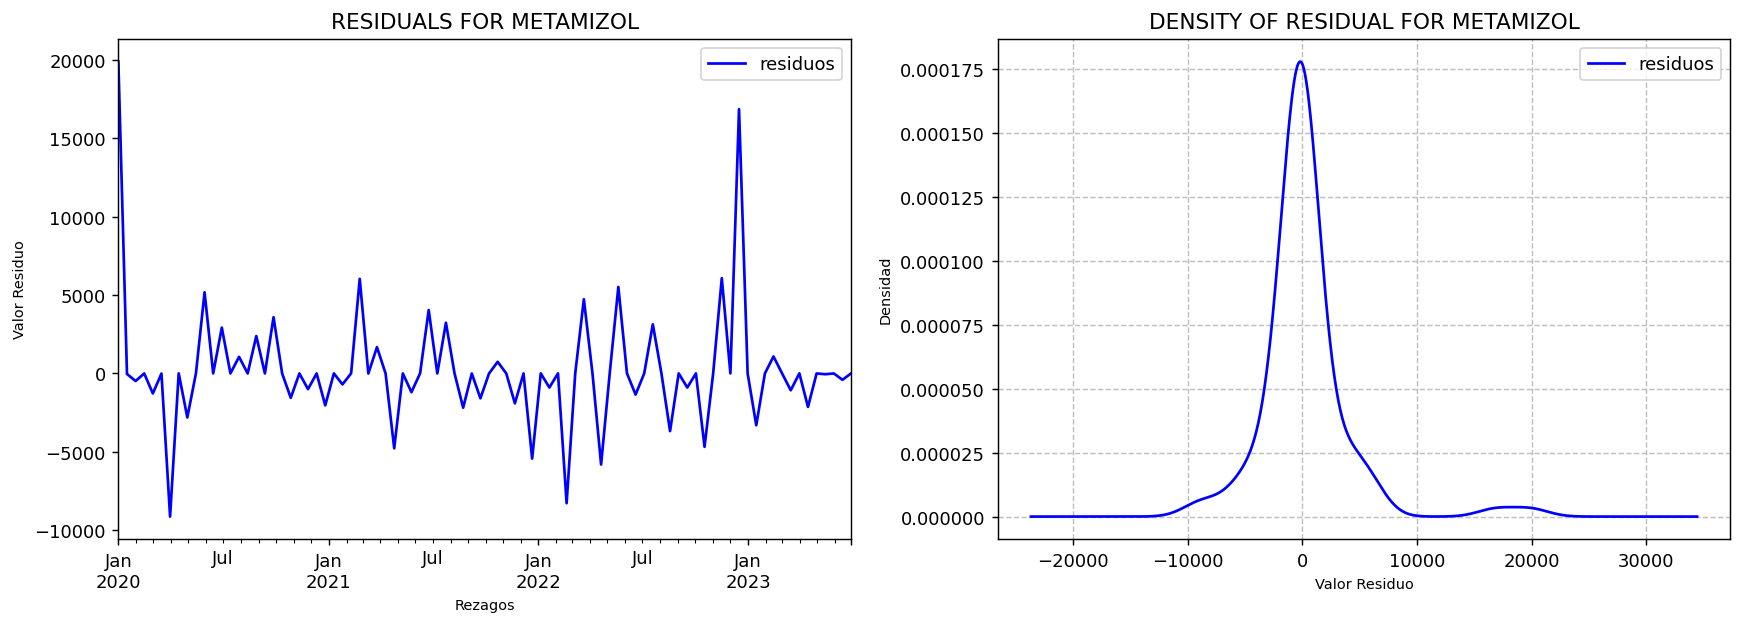

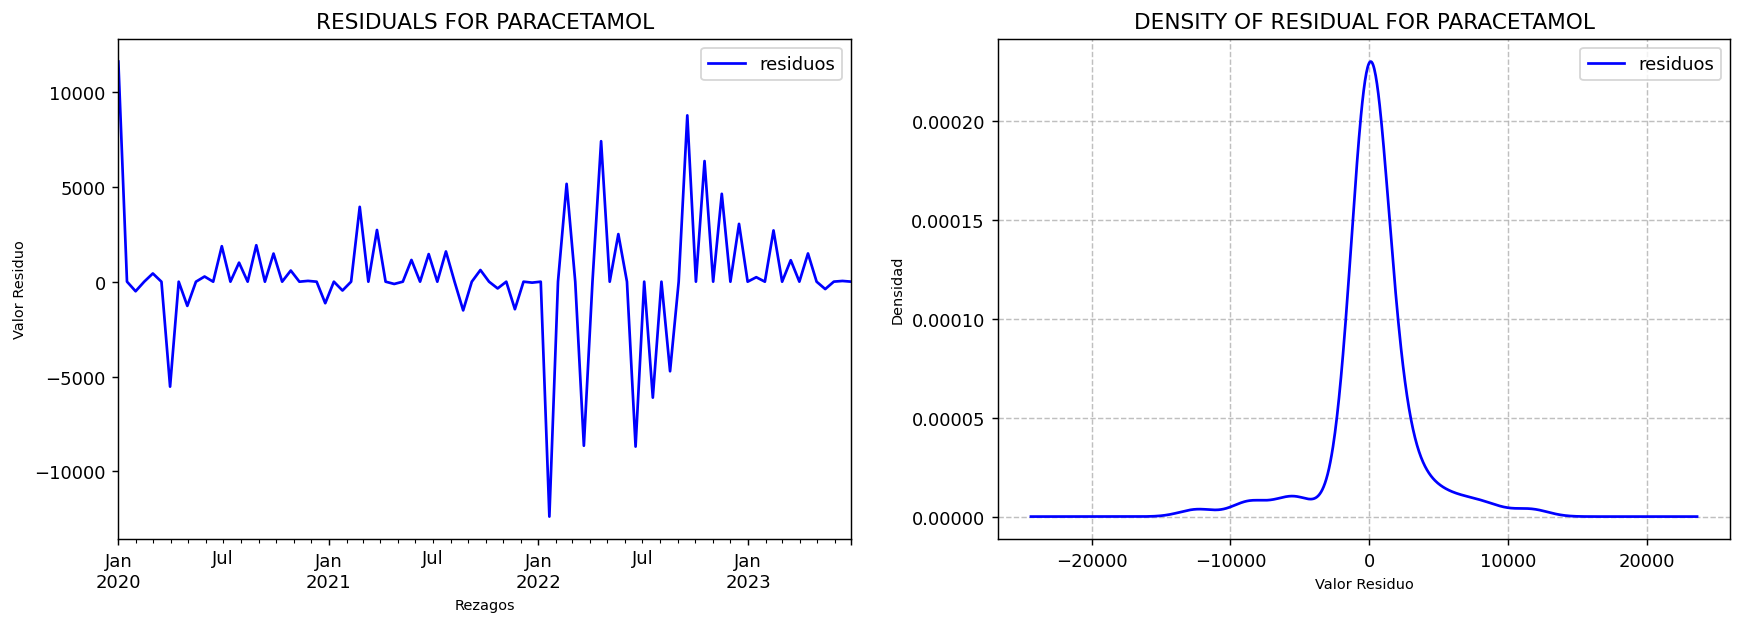

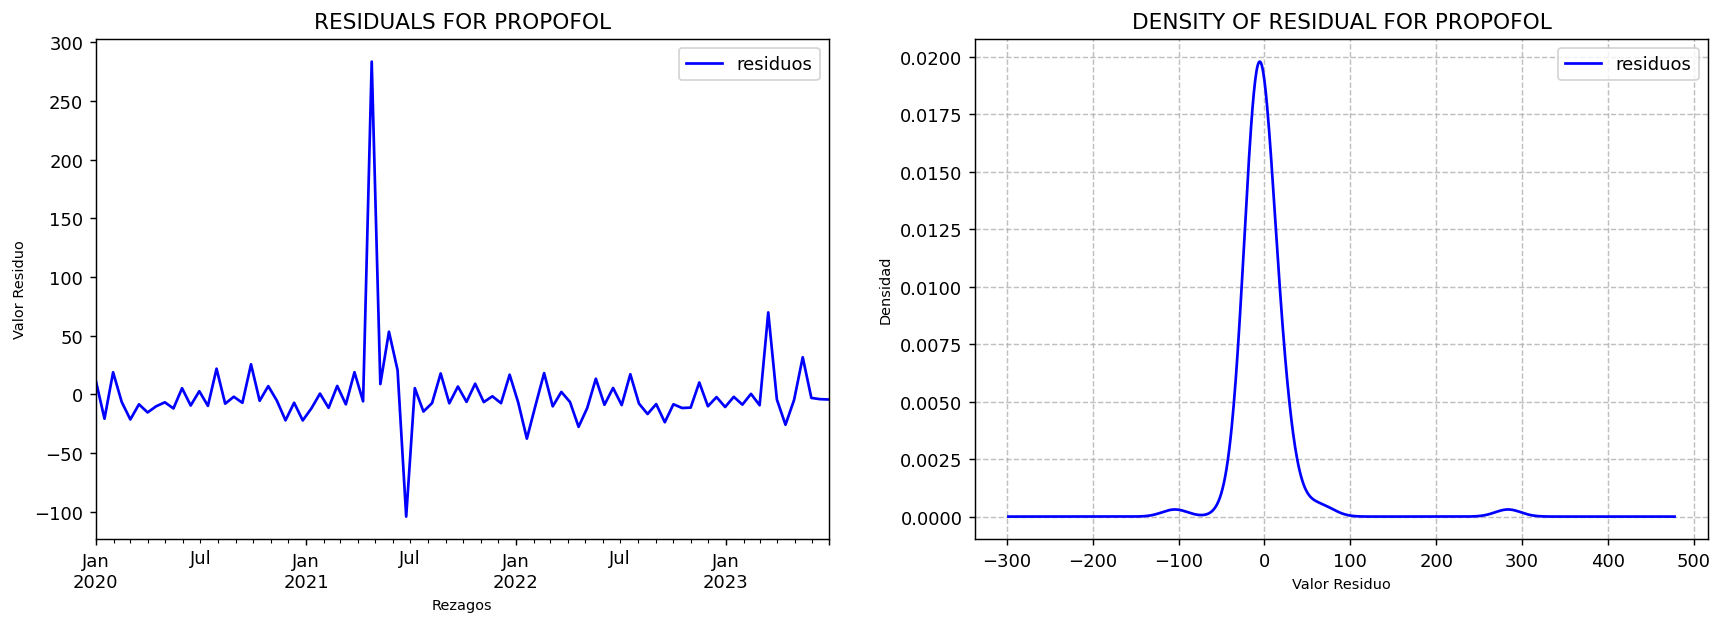

In [80]:
# Iterate over each trained ARIMA model
for series, model_fit in trained_models.items():
    # Plot residual errors and their density for the current series
    plot_residual_errors(series, model_fit)

##### Fitting The ARIMA Model to The Training Data

In [81]:
"""
    Plot the real values versus the adjusted values for a given series, along with the confidence interval.

    Parameters:
    - series (str): The name of the series.
    - forecasting (pandas DataFrame): DataFrame containing the predicted values.
    - forecasting_ci (pandas DataFrame): DataFrame containing the confidence intervals.

    Returns:
    - None
"""
def plot_model_fit(series, forecasting, forecasting_ci):

    plt.plot(training[series], label='Valores Reales', linewidth=3, linestyle='solid')
    plt.plot(
        forecasting.predicted_mean.index[1:],
        forecasting.predicted_mean.values[1:],
        color='red',
        label='Valores Ajustados',
        linewidth=2,
        linestyle='solid'
    )

    plt.fill_between(
        forecasting_ci.index[1:],
        forecasting_ci.iloc[1:, 0],
        forecasting_ci.iloc[1:, 1],
        color='green',
        alpha=0.3,
        label='Intervalos de confianza'
    )

    plt.grid(True, linestyle='--', alpha=0.8)

    plt.title(f'Valores reales vs Valores ajustados para {series}'.upper())
    plt.legend()
    plt.show()

In [82]:
# List to store training metrics
training_metrics = []

# Iterate over each trained ARIMA model
for series, model_fit in trained_models.items():

    # Make predictions using the fitted model
    forecasting = model_fit.get_prediction(start=0, dynamic=False)
    forecasting_ci = forecasting.conf_int()

    # Calculate evaluation metrics
    mae = mean_absolute_error(training[series], forecasting.predicted_mean)
    mse = mean_squared_error(training[series], forecasting.predicted_mean)
    rmse = np.sqrt(mse)

    # Store the metrics in the list
    training_metrics.append({
        'SERIES': series,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

    # Plot the model fit
    plot_model_fit(series, forecasting, forecasting_ci)

Output hidden; open in https://colab.research.google.com to view.

##### Performance Metrics for The Training Dataset

In [83]:
# Create a DataFrame from the list of training metrics
pd.DataFrame(training_metrics).round(decimals=2)

,SERIES,MAE,MSE,RMSE
0,CLORURO DE SODIO,833.73,2592520.43,1610.13
1,LACTATO DE SODIO,791.29,2485954.66,1576.69
2,METAMIZOL,1831.58,14292390.82,3780.53
3,PARACETAMOL,1482.38,9567234.01,3093.09
4,PROPOFOL,16.41,1318.51,36.31


##### Out-of-Sample Cross-Validation

In [93]:
"""
    Plot the cross-validation results for a given series.

    Parameters:
    - series (str): The name of the series.
    - forecast_values (array-like): Forecasted values for the series.
    - conf_ranges (pandas DataFrame): DataFrame containing confidence intervals for the forecasted values.

    Returns:
    - None
"""

def plot_cross_validation(series, forecast_values, conf_ranges):

    forecasting_series = pd.Series(forecast_values, test[series].index)
    lower_series = pd.Series(conf_ranges[conf_ranges.columns[0]], test[series].index)
    upper_series = pd.Series(conf_ranges[conf_ranges.columns[1]], test[series].index)

    y_label = 'Quantity (L)' if series == 'CLORURO DE SODIO' or series == 'LACTATO DE SODIO' else 'Quantity (G)'

    plt.figure(figsize=(16,5))
    plt.plot(training[series], label='Training', linewidth=3, linestyle='solid')
    plt.plot(test[series], label='Test', linewidth=3, linestyle='solid')
    plt.plot(forecasting_series, label='Forecasting', linewidth=2, linestyle='dashed')

    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.20)
    plt.grid(True, linestyle='--', alpha=1)
    plt.legend(fontsize=13)

    plt.xlabel('Months', fontsize=13)
    plt.ylabel(y_label, fontsize=13)
    serie_name = translator.translate(series, src='es', dest='en')
    serie_name = serie_name.text
    plt.title(f'Forecasting for {serie_name}'.upper(), fontsize=15)
    plt.legend(loc='upper left', fontsize=10)
    plt.savefig(f"fig_4_{serie_name}.png")

    plt.show()

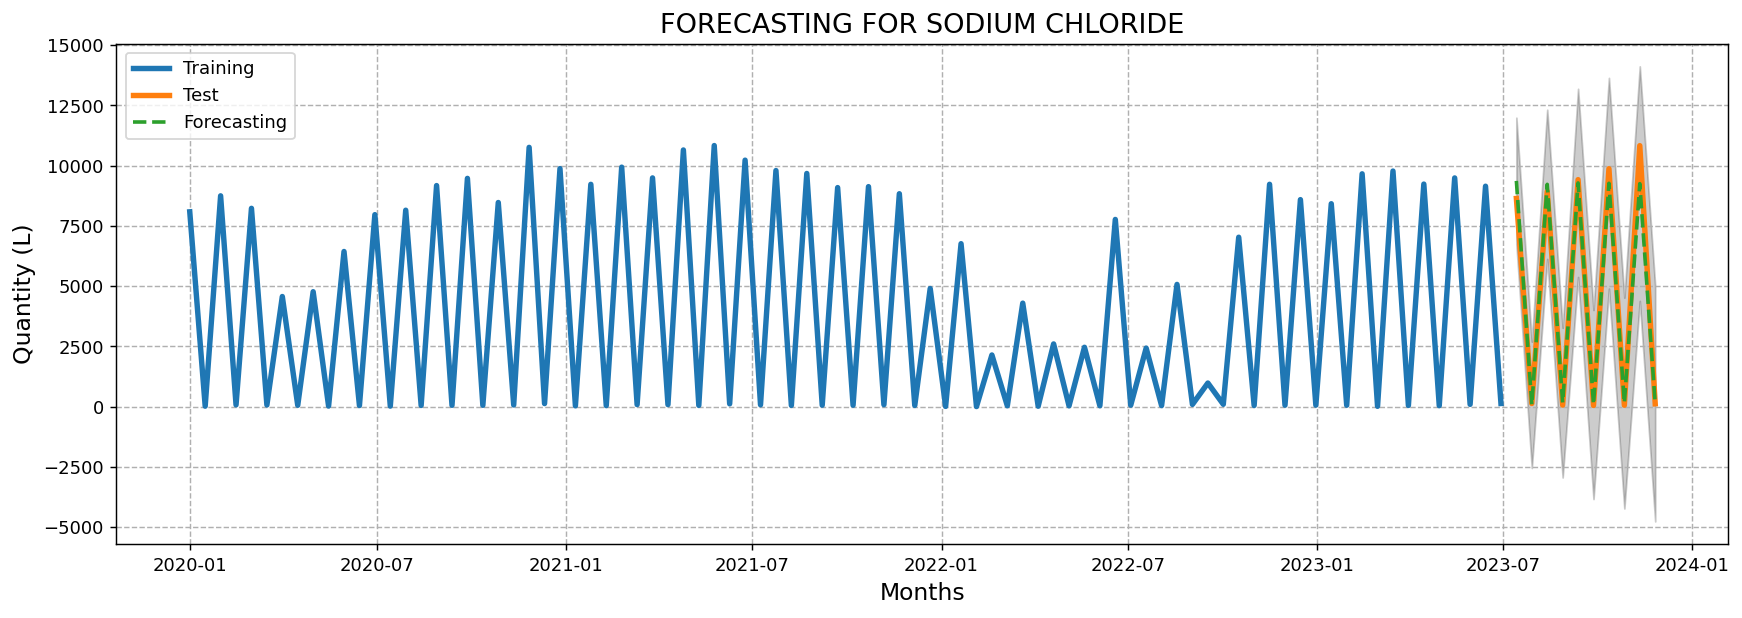

CLORURO DE SODIO,REAL,FORECAST
FECHA,,
2023-07-14,8639.62,9368.035068
2023-07-29,129.90,76.030229
2023-08-13,8929.96,9225.038245
2023-08-28,63.15,167.797786
2023-09-12,9420.57,9283.458903
2023-09-27,48.90,89.206711
2023-10-12,9875.78,9269.478076
2023-10-27,57.80,150.023374
2023-11-11,10830.82,9253.299426


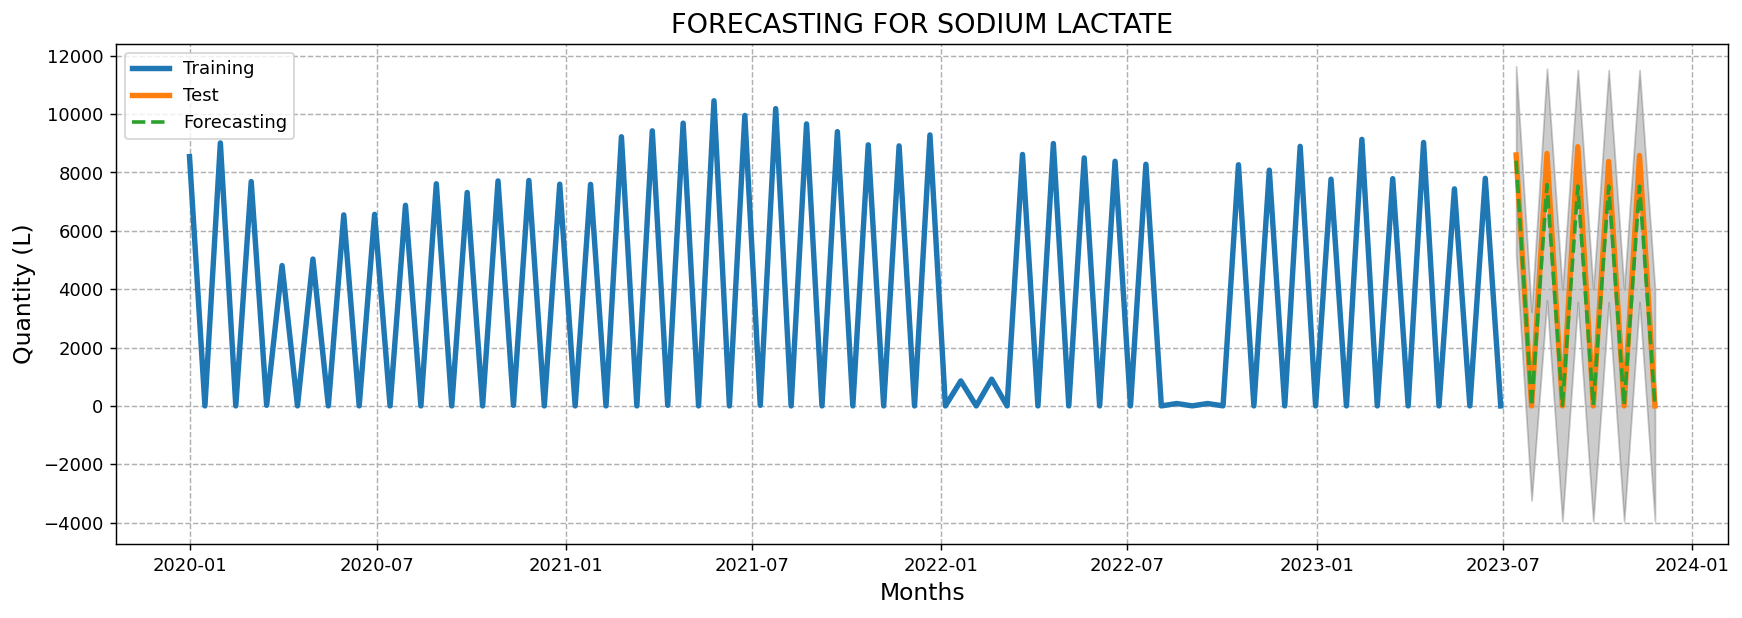

LACTATO DE SODIO,REAL,FORECAST
FECHA,,
2023-07-14,8600.5,8403.711303
2023-07-29,0.0,-4.581431
2023-08-13,8651.0,7584.182720
2023-08-28,0.0,18.465605
2023-09-12,8882.5,7534.878522
2023-09-27,0.5,20.939725
2023-10-12,8377.5,7531.691614
2023-10-27,0.0,21.358172
2023-11-11,8581.0,7531.280893


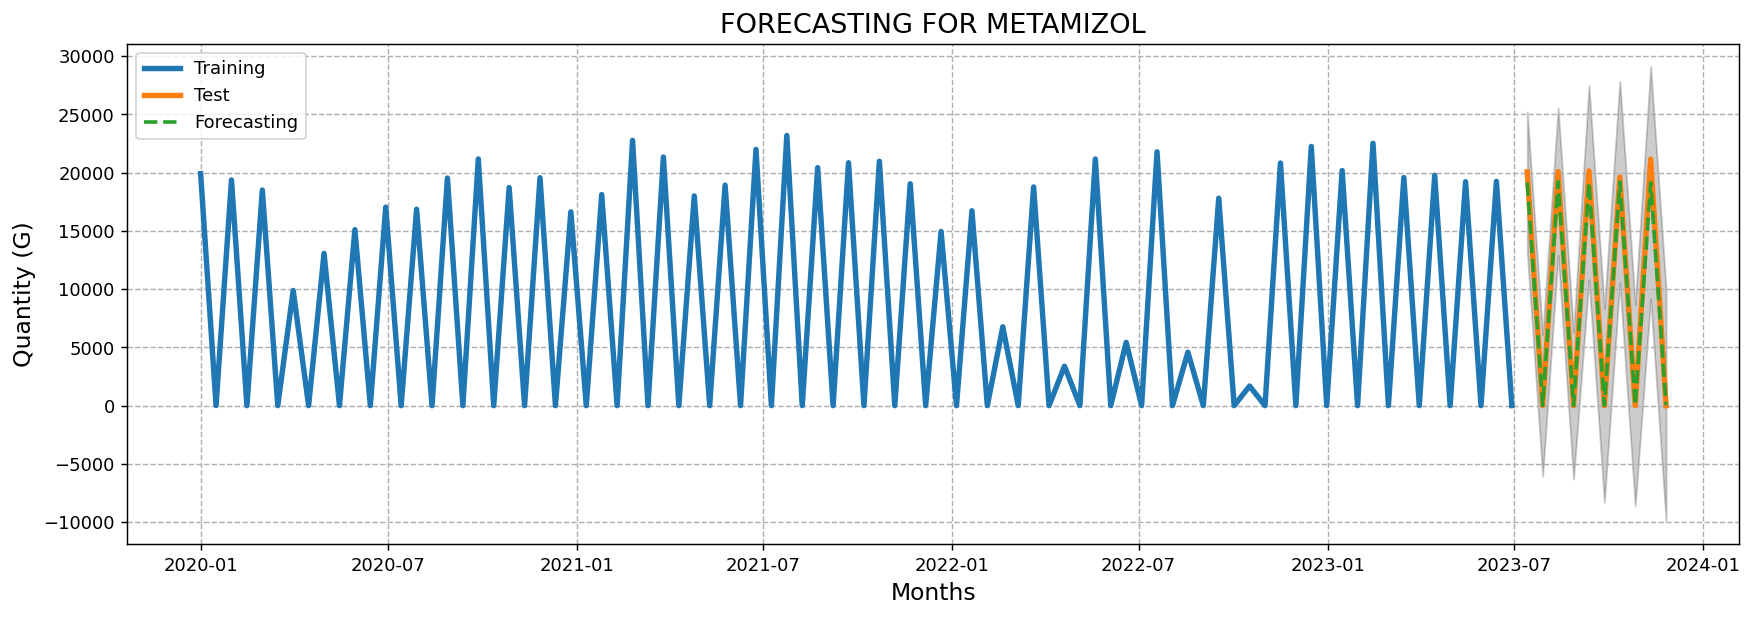

METAMIZOL,REAL,FORECAST
FECHA,,
2023-07-14,20066.80,19150.924336
2023-07-29,16.00,15.398978
2023-08-13,20095.76,19224.148202
2023-08-28,5.00,20.508550
2023-09-12,20149.52,19150.226820
2023-09-27,2.00,27.578003
2023-10-12,19618.72,19201.895239
2023-10-27,0.00,32.956065
2023-11-11,21154.56,19146.385245


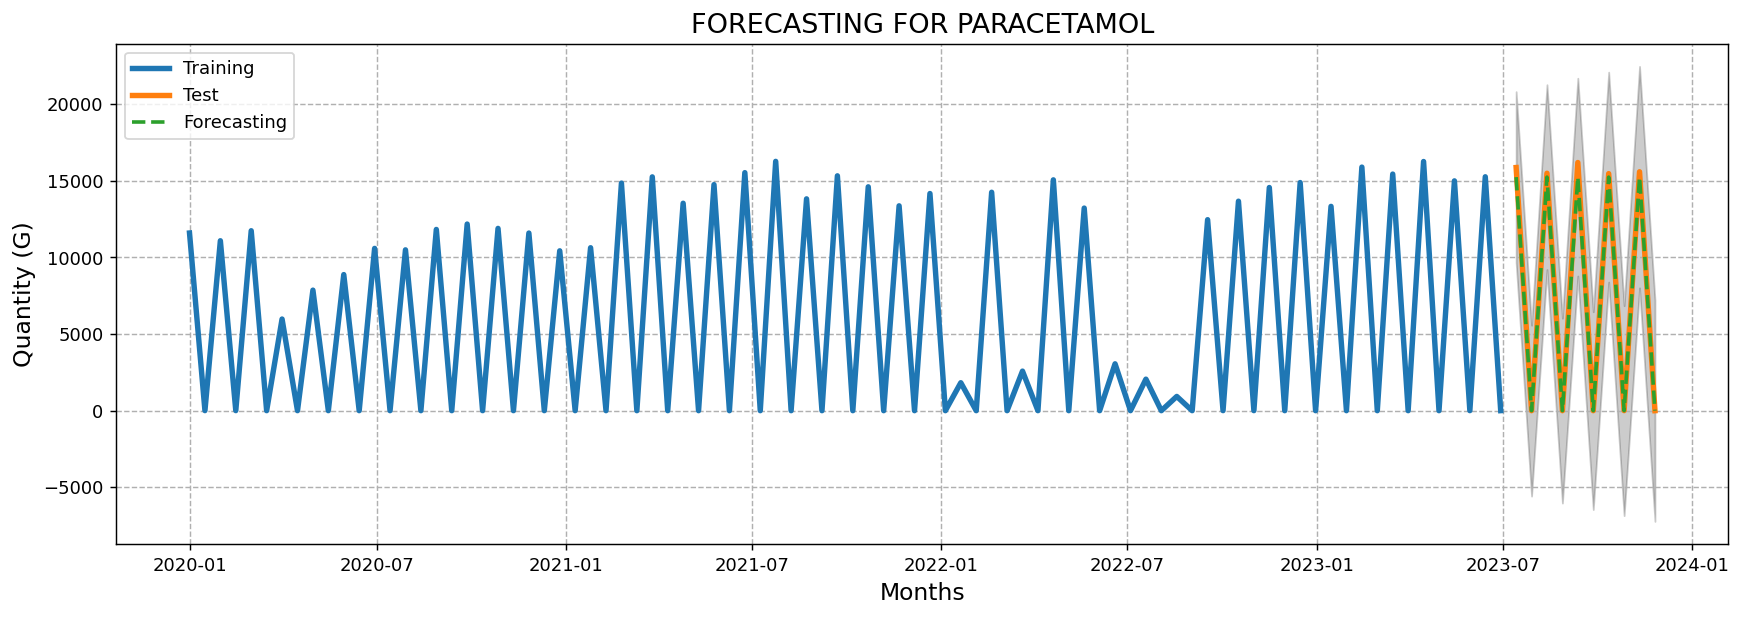

PARACETAMOL,REAL,FORECAST
FECHA,,
2023-07-14,15869.500,15243.361672
2023-07-29,0.000,1.979110
2023-08-13,15496.500,15243.330668
2023-08-28,0.000,2.009882
2023-09-12,16197.000,15243.299895
2023-09-27,0.000,2.040654
2023-10-12,15472.000,15243.269123
2023-10-27,3.000,2.071426
2023-11-11,15592.875,15243.238352


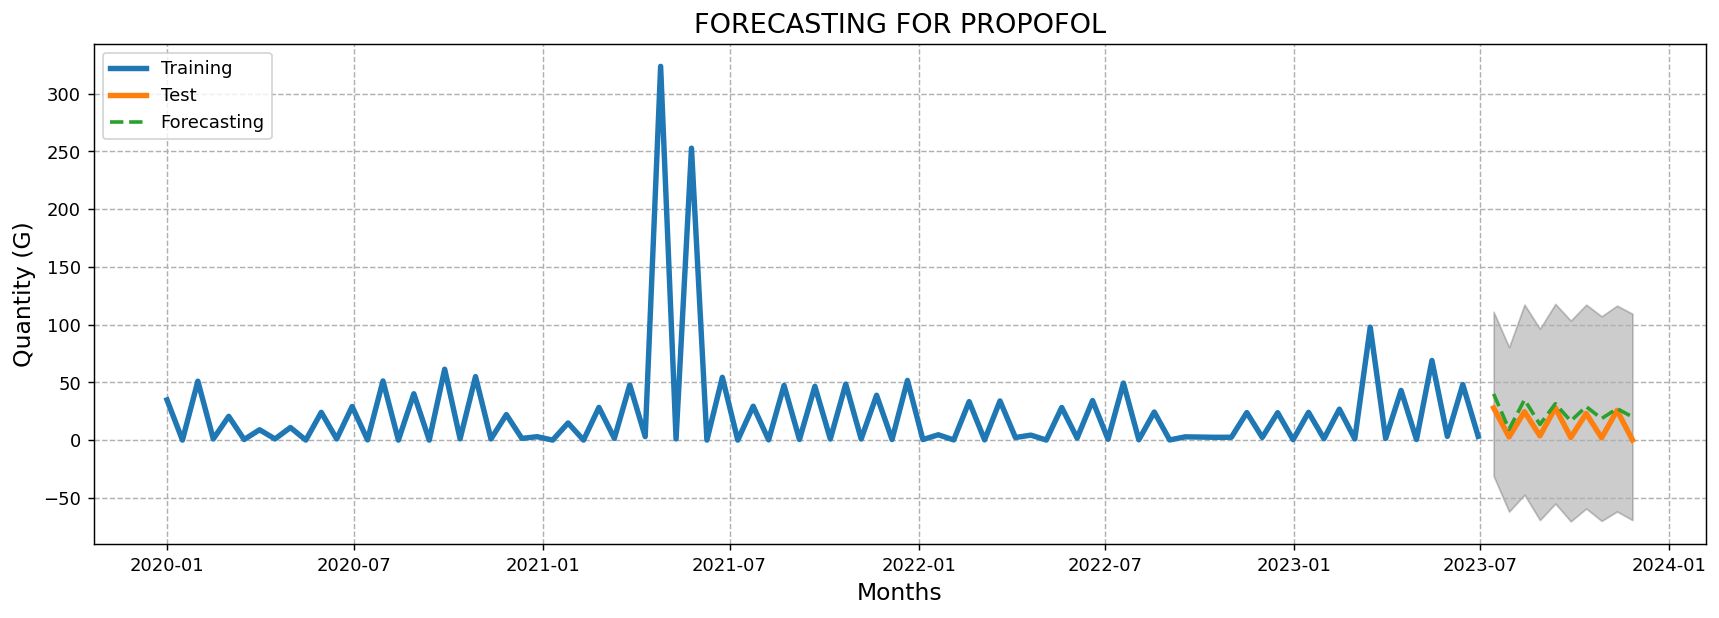

PROPOFOL,REAL,FORECAST
FECHA,,
2023-07-14,27.87,40.024451
2023-07-29,2.74,9.293739
2023-08-13,24.61,34.996605
2023-08-28,3.68,13.576272
2023-09-12,28.01,31.483914
2023-09-27,2.29,16.551282
2023-10-12,23.02,29.028934
2023-10-27,1.98,18.620010
2023-11-11,25.67,27.314843


In [94]:
# List to store cross-validation metrics
metrics = []

# Iterate over each trained ARIMA model
for series, model_fit in trained_models.items():

    # Make forecasts using the fitted model
    forecast = model_fit.get_forecast(steps=len(test[series]), alpha=0.05)
    forecast_values = forecast.predicted_mean
    conf_ranges = forecast.conf_int()

    # Calculate evaluation metrics
    mae = mean_absolute_error(test[series], forecast_values)
    mse = mean_squared_error(test[series], forecast_values)
    rmse = np.sqrt(mse)

    # Creating a dataframe with forecasted values
    series_forecast = pd.DataFrame({
        'REAL': test[series],
        'FORECAST': forecast_values
    }, index=test.index)

    # Assigning a name to the index of the columns
    series_forecast.columns.name = series

    # Store the metrics in the list
    metrics.append({
        'SERIES': series,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

    # Show the cross-validation results
    plot_cross_validation(series, forecast_values, conf_ranges)
    display(series_forecast)

##### Performance Metrics for The Test Dataset

In [ ]:
pd.DataFrame(metrics).round(decimals=2)

##### Future Forecasts

In [ ]:
future_forecast_models = {}

# Iterate over each configuration in the config_list
for params in config_list:

    # Extract series name and ARIMA orders from the configuration
    series = params['series']
    order = params['order']

    # Fit an ARIMA model to the time series data for the current series
    model = ARIMA(time_series[series], order=order)
    model_fit = model.fit()

    # Store the trained model in the dictionary
    future_forecast_models[series] = model_fit

    # Print summary of each of the models
    print(model_fit.summary())

In [ ]:
"""
    Plot the future forecast for a given series.

    Parameters:
    - series (str): The name of the series.
    - forecast_values (array-like): Forecasted values for the future.

    Returns:
    - None
"""
def plot_future_forecast(series, forecast_values):

    training_series = time_series[series][:-10]
    test_series  = time_series[series][-10:]

    y_label = 'Cantidad (L)' if series == 'CLORURO DE SODIO' or series == 'LACTATO DE SODIO' else 'Cantidad (G)'

    plt.figure(figsize=(16,5))
    plt.plot(training_series, label='Entrenamiento', linewidth=3, linestyle='solid')
    plt.plot(test_series, label='Prueba', linewidth=3, linestyle='dashed')
    plt.plot(forecast_values, label='Pronósticos', linewidth=3, linestyle='dashed')

    plt.grid(True, linestyle='--', alpha=1)
    plt.legend(fontsize=13)

    plt.xlabel('Meses', fontsize=13)
    plt.ylabel(y_label, fontsize=13)

    plt.title(f'Pronósticos para los siguientes 5 meses - {series}'.upper(), fontsize=15)
    plt.legend(loc='upper left', fontsize=10)

    plt.show()

In [ ]:
for series, model_fit in future_forecast_models.items():

    # Make forecasts using the fitted model
    forecast = model_fit.get_forecast(steps=10, alpha=0.05)
    forecast_values = forecast.predicted_mean

    # Creating a dataframe with forecasted values
    series_forecast = pd.DataFrame({
        'REAL': 'Unknown',
        'FORECAST': forecast_values
    })

    # Assigning a name to the index of the columns
    series_forecast.columns.name = series

    # Show the cross-validation results
    plot_future_forecast(series, forecast_values)
    display(series_forecast)